In [42]:
import pandas as pd
from bs4 import BeautifulSoup             
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

In [43]:
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
train = train.drop(['id'], axis=1)
train.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [44]:
df = pd.read_csv('imdb_master.csv',encoding="latin-1")

In [45]:
df = df.drop(['Unnamed: 0','type','file'],axis=1)
df.columns = ["review","sentiment"]
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [46]:
df = df[df.sentiment != 'unsup']
df['sentiment'] = df['sentiment'].map({'pos': 1, 'neg': 0})
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [47]:
training = pd.concat([train, df]).reset_index(drop=True)
training.shape

(75000, 2)

In [48]:
# function to convert a raw review to a string of words
# inputs = a raw movie review) and output = pre-processed review 

def review_to_words(raw_review):

    # remove HTML
    review_text = BeautifulSoup(raw_review,).get_text() 
    
    # remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # convert to lower case and split into individual words
    words = letters_only.lower().split()                                             
    
    # stop words conversion to set cause faster than list
    stops = set(stopwords.words("english"))                  
    
    # remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # join words into one string
    return( " ".join(meaningful_words))   

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattiaruefenacht/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [51]:
num_reviews = training["review"].size

# initialize an empty list for preprossed reviews
# and loop over each review and add index from 0 to n
print ("Cleaning and parsing the training set movie reviews...\n")

clean_train_reviews = []

for i in range(0, num_reviews):
    if((i)%5000 == 0 ):
        print ("Review %d of %d\n" % (i, num_reviews ))                                                                 
    
    clean_train_reviews.append(review_to_words(training["review"][i]))

print("Done")

Cleaning and parsing the training set movie reviews...

Review 0 of 75000

Review 5000 of 75000

Review 10000 of 75000

Review 15000 of 75000

Review 20000 of 75000

Review 25000 of 75000

Review 30000 of 75000

Review 35000 of 75000

Review 40000 of 75000

Review 45000 of 75000

Review 50000 of 75000

Review 55000 of 75000

Review 60000 of 75000

Review 65000 of 75000

Review 70000 of 75000

Done


In [52]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# initialize CountVectorizer object 
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000) 

# give list of string to fit_transform
train_data_features = vectorizer.fit_transform(clean_train_reviews)

train_data_features = train_data_features.toarray()
print ("Done")

Creating the bag of words...

Done


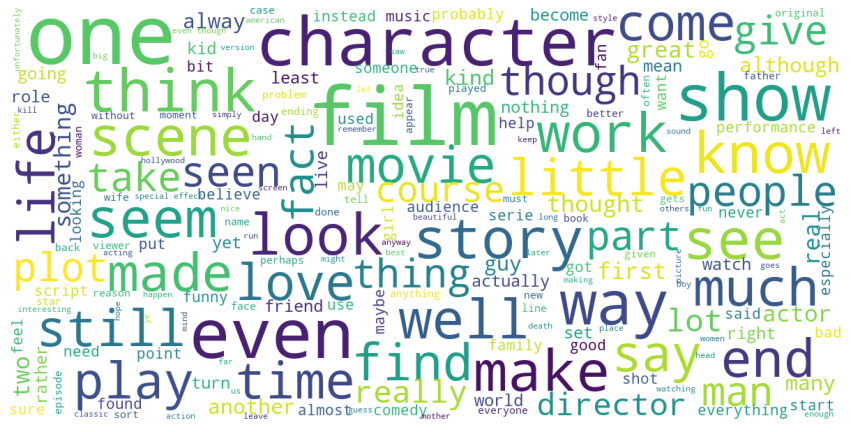

In [55]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=42).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(clean_train_reviews)

In [56]:
# splite dataset into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data_features, training["sentiment"], test_size=0.2, random_state=42)

print("Splitting Done")

Splitting Done


In [57]:
print ("Training random forest model...")
from sklearn.ensemble import RandomForestClassifier

# initialize a random forest classifier with 150 trees
forest = RandomForestClassifier(n_estimators = 150) 


forest = forest.fit(x_train, y_train )

print ("Done")

Training random forest model...
Done


In [58]:
result = forest.predict(x_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, result)
accuracy

0.9336

In [59]:
f1 = f1_score(y_test, result)
f1

0.932657200811359

In [60]:
conf_matrix = confusion_matrix(y_test, result)
conf_matrix

array([[7107,  466],
       [ 530, 6897]])

In [62]:
from nltk.corpus import stopwords

test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

# verify df shape
print (test.shape)

# create an empty list and append the clean reviews
num_reviews = len(test["review"])
clean_test_reviews = [] 

print ("Cleaning and parsing the test set movie reviews...\n")

for i in range(0,num_reviews):
    if( (i) % 5000 == 0 ):
        print ("Review %d of %d\n" % (i, num_reviews))
    clean_review = review_to_words(test["review"][i])
    clean_test_reviews.append(clean_review)

test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

result = forest.predict(test_data_features)

# insert results into df with an id and sentiment output
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})

output.to_csv("Bag_of_Words_model.csv", index=False, quoting=3)

print("Done")

(25000, 2)
Cleaning and parsing the test set movie reviews...

Review 0 of 25000

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Done
